# NGBoost

NGBoost (Natural Gradient Boosting) is a method for probabilistic regression that extends gradient boosting to predict full probability distributions instead of just point estimates.

**Key Ideas**

- Models the full probability distribution of the target variable, not just a single value.
- For instance, when modeling a normal distribution, NGBoost predicts both the loc (μ) and scale (σ) of the distribution as a target.
- Uses the Natural Gradient to optimize.
- Gradient boosting is a supervised learning method that builds an ensemble of weak learners in a sequential training process.
- NGBoost package: Can be used with any base learner and custom family of distributions with continuous parameters.

**Model documentation**: 

- introduction: https://stanfordmlgroup.github.io/projects/ngboost/
- paper: https://arxiv.org/pdf/1910.03225
- github: https://github.com/stanfordmlgroup/ngboost
- user guide: https://stanfordmlgroup.github.io/ngboost/intro.html
- **guide to add new distribution target and scoring**: https://stanfordmlgroup.github.io/ngboost/5-dev.html

**Requirements:**

!pip install birdgame

!pip install ngboost

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            },
                "weight": weight
}
```

A **mixture density**, such as the gaussion mixture $\sum_{i=1}^{K} w_i \mathcal{N}(Y_t | \mu_i, \sigma_i^2)$ allows for capturing multi-modal distributions and approximate more complex distributions.

![proba_forecast_v3](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v3.png?raw=true)


**Probabilistic Forecasting** is particularly valuable in supply chain management. Below are some interesting resources for a deeper understanding:  

- [Probabilistic Forecasting](https://www.lokad.com/probabilistic-forecasting-definition/) – Overview of probabilistic forecasting and its applications.  
- [Quantile Forecasting](https://www.lokad.com/quantile-regression-time-series-definition/) – Explanation of quantile-based forecasting methods.  
- **Evaluation Metrics:**  
  - [Continuous Ranked Probability Score (CRPS)](https://www.lokad.com/continuous-ranked-probability-score/)  
  - [Cross-Entropy](https://www.lokad.com/cross-entropy-definition/)  
  - [Pinball Loss](https://www.lokad.com/pinball-loss-function-definition/)

In [1]:
# Standard library imports
# !pip install birdgame
# !pip install ngboost
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

try:
    from birdgame.trackers.trackerbase import TrackerBase
except:
    # Trick to be on root directory (to remove in the future and use install birdgame)
    # Change the working directory to the root of the package
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
    os.chdir(root_dir)
    
# Birdgame package imports
from birdgame.trackers.trackerbase import TrackerBase
from birdgame.visualization.viz_ngboost import visualize_ngboost

### Warm up example: NGBoost

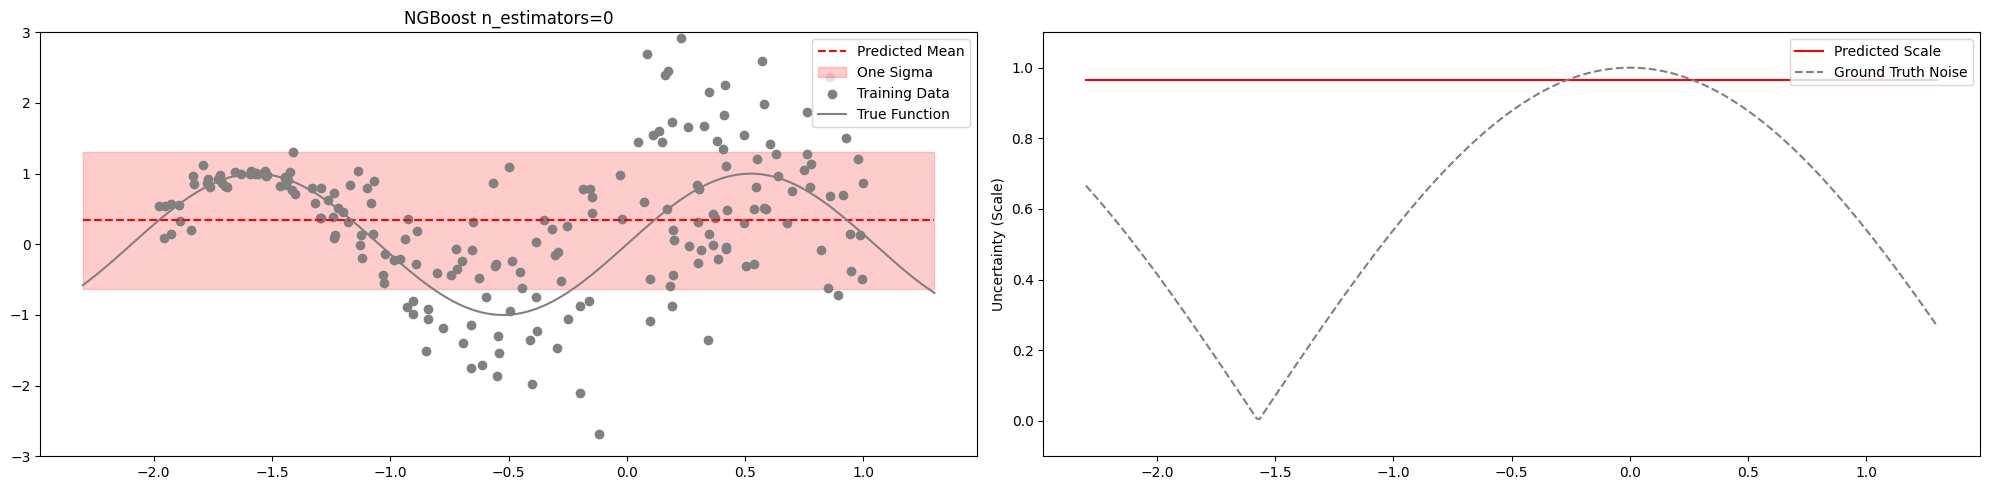

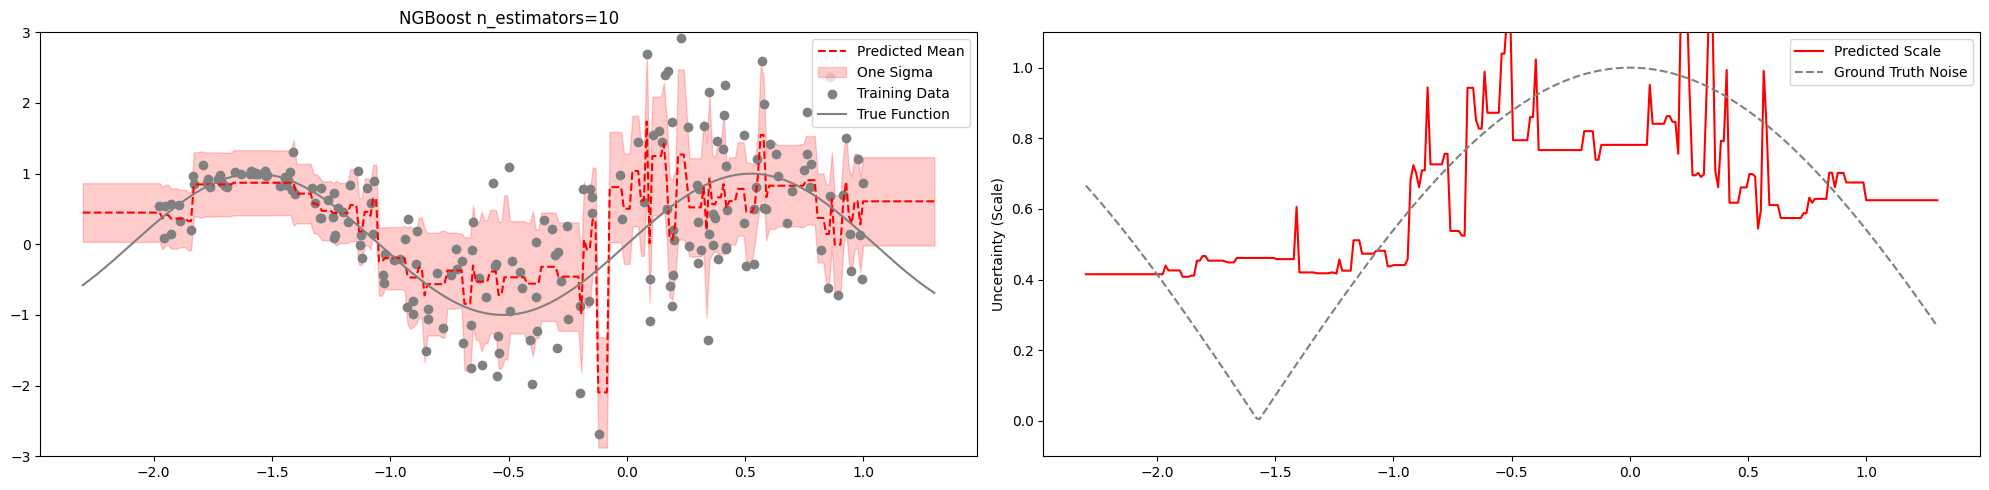

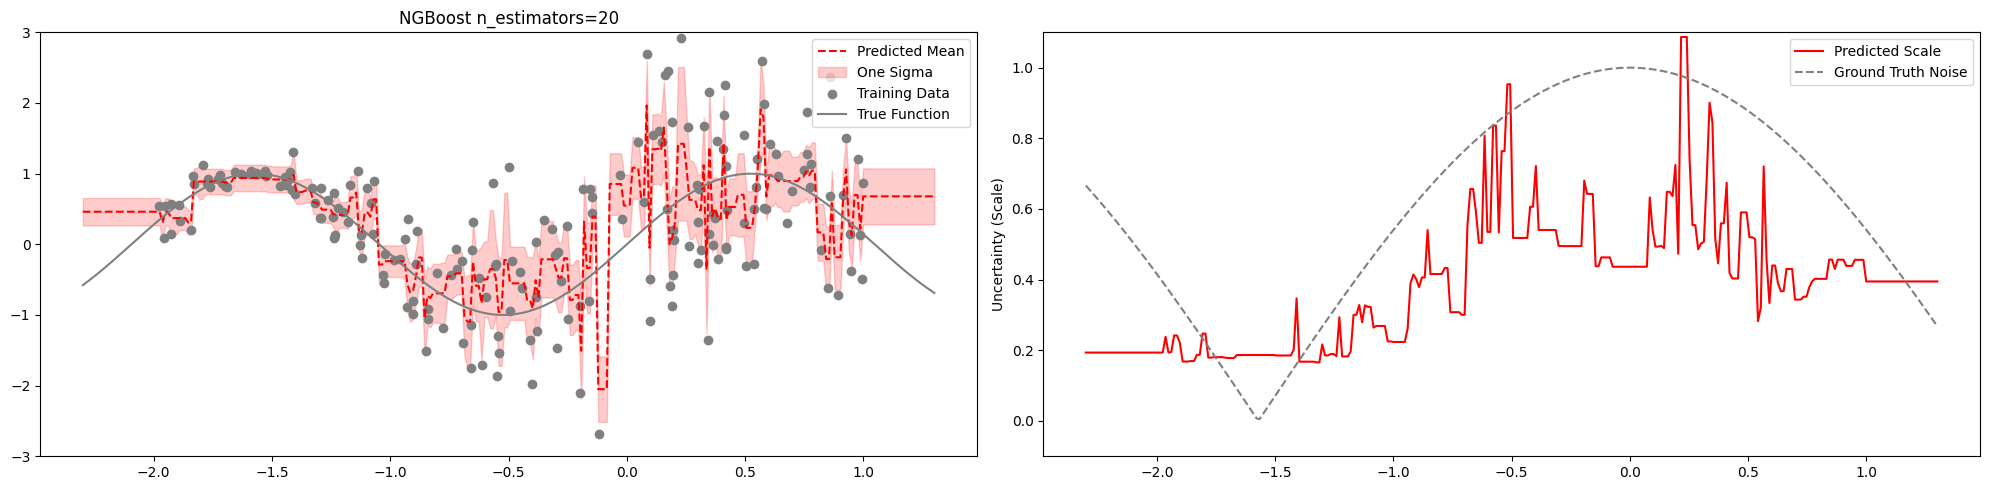

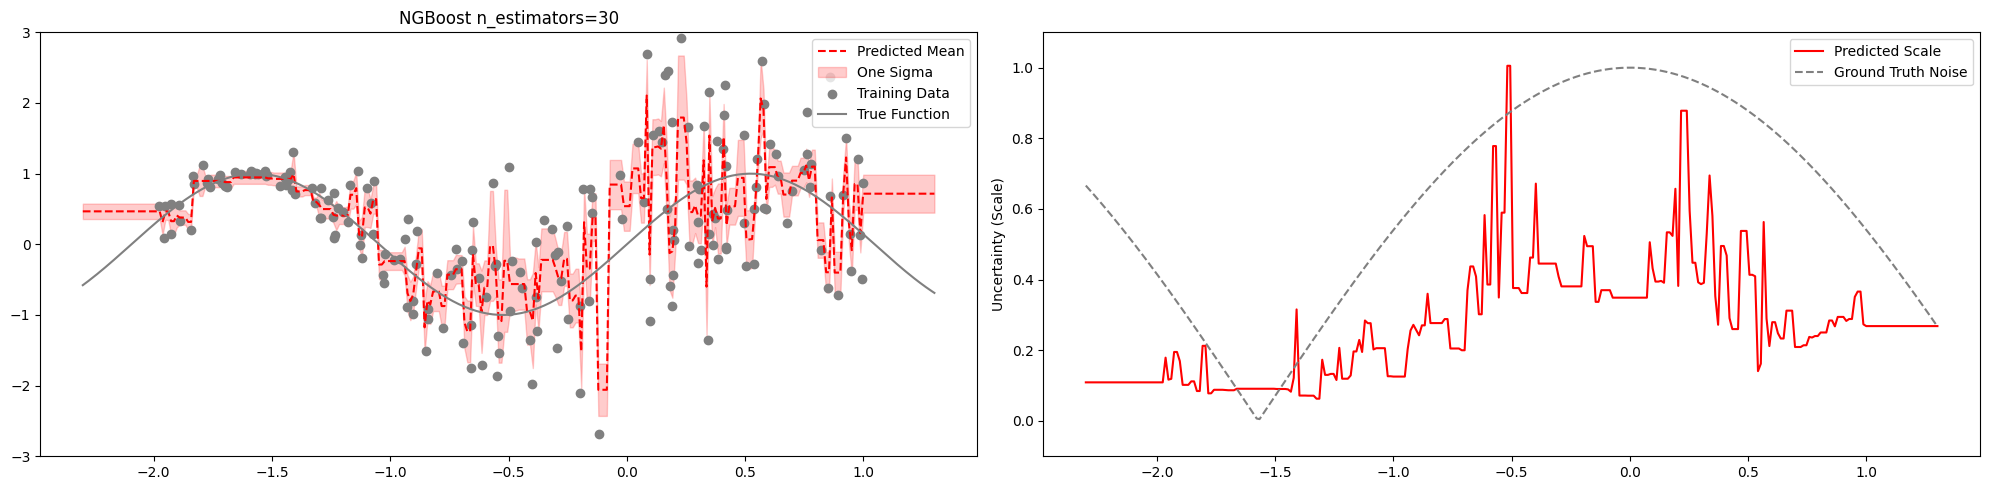

In [2]:
# Run NGBoost for different number of estimators
visualize_ngboost(max_n_estimators=40, step=10, n_data_samples=200)

In [4]:
import numpy as np
from ngboost import NGBoost
from ngboost.distns import Normal
from sklearn.tree import DecisionTreeRegressor
    

class NGBoostTracker(TrackerBase):
    """
    A model that tracks the dove location using NGBoost.

    Parameters
    ----------
    horizon : int
        The number of time steps into the future that predictions should be made for.
    train_model_frequency : int
        The frequency at which the NGBoost model will be retrained based on the count of observations 
        ingested. This determines how often the model will be updated with new data.
    num_data_points_max : int
        The maximum number of data points to use for training the NGBoost model.
    window_size : int
        The number of previous data points (the sliding window size) used to predict the future value 
        at the horizon. It defines how many past observations are considered for prediction.
    """
    def __init__(self):
        super().__init__(Constants.HORIZON)
        self.current_x = None
        self.last_observed_data = [] # Holds the last few observed data points
        self.x_y_data = [] # Holds pairs of previous and current data points

        self.train_model_frequency = Constants.TRAIN_MODEL_FREQUENCY
        self.num_data_points_max = Constants.NUM_DATA_POINTS_MAX # (X.shape[0])
        self.window_size = Constants.WINDOW_SIZE # (X.shape[1])

        # Initialize the NGBoost model
        self.model = NGBoost(Dist=Normal, learning_rate=0.1, n_estimators=50, natural_gradient=True, verbose=False, random_state=15,
                             validation_fraction=0.1, early_stopping_rounds=None,
                             Base=DecisionTreeRegressor(
                                    criterion="friedman_mse",
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_depth=5,
                                    splitter="best",
                                    random_state=None,
                                ))

    def tick(self, payload):
        """
        Ingest a new record (payload), store it internally and update the model.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        """
        x = payload['dove_location']
        t = payload['time']
        self.add_to_quarantine(t, x)
        self.last_observed_data.append(x)
        self.current_x = x
        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:
            self.x_y_data.append((prev_x, x))

            if self.count > self.window_size and self.count%self.train_model_frequency == 0:
                
                x_y_data = np.array(self.x_y_data)
                xi_values = x_y_data[:, 0]
                yi_values = x_y_data[:, 1]

                # Determine the number of data points to use for training
                num_data_points = min(len(xi_values), self.num_data_points_max)
                if len(xi_values) < self.num_data_points_max + self.window_size:
                    num_data_points = num_data_points - (self.window_size + 3)

                # Construct 'X' with fixed-size slices and 'y' as the values to predict
                X = np.lib.stride_tricks.sliding_window_view(xi_values[-(num_data_points + self.window_size - 1):], self.window_size)
                y = yi_values[-num_data_points:]

                # Fit a single NGBoost model (since we only need one model)
                self.model.fit(X, y)

                # Keep only latest data (to limit memory usage as it will be run on continuous live data)
                self.x_y_data = self.x_y_data[-(self.num_data_points_max + self.window_size * 2):]
                self.last_observed_data = self.last_observed_data[-(self.window_size+1):]
            self.count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution,
        modeled as a Gaussian distribution.
        """
        # the central value (mean) of the gaussian distribution will be represented by the current value
        x_mean = self.current_x
        components = []

        try:
            X_input = np.array([self.last_observed_data[-(self.window_size+1):]])

            # Get the predicted distribution
            y_test_ngb = self.model.pred_dist(X_input)

            # here we use current value as loc but you can get the parameter loc from ngboost normal distribution class: y_test_ngb.loc[0]
            loc = x_mean 

            scale = y_test_ngb.scale[0] # get the parameter scale from ngboost normal distribution class
            scale = max(scale, 1e-6)
        except:
            loc = x_mean
            scale = 1e-6

        components = {
            "density": {
                "type": "builtin",
                "name": "norm",
                "params": {"loc": loc, "scale": scale}
            },
            "weight": 1
        }

        prediction_density = {
            "type": "mixture",
            "components": [components]
        }

        return prediction_density


### Tracker experimentation

The model is experimented on a data generator using the [density_pdf](https://github.com/microprediction/densitypdf/blob/main/densitypdf/__init__.py) scoring. For a gaussian distribution, it is:

$$\text{pdf\_score}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

This metric measures how well the predicted distribution aligns with the observed data. **A higher pdf_score indicates a more accurate prediction.**

In [5]:
# Parameters
class Constants:
    HORIZON = 10
    TRAIN_MODEL_FREQUENCY=100
    NUM_DATA_POINTS_MAX=1000
    WINDOW_SIZE = 5

### Run on a remote static data file

In [5]:
# Initialize Tracker
tracker = NGBoostTracker()

# Run on remote data
tracker.test_run(live=False)

0it [00:00, ?it/s]

My likelihood score: -7.4473 VS Benchmark likelihood score: 2.5298
     .... and mine is worse. Ratio is -2.94379
My likelihood score: -4.7617 VS Benchmark likelihood score: 2.4641
     .... and mine is worse. Ratio is -1.93241
My likelihood score: -3.6630 VS Benchmark likelihood score: 2.4350
     .... and mine is worse. Ratio is -1.50434
My likelihood score: -2.6483 VS Benchmark likelihood score: 2.5580
     .... and mine is worse. Ratio is -1.03531
My likelihood score: -2.2605 VS Benchmark likelihood score: 2.6113
     .... and mine is worse. Ratio is -0.86568
My likelihood score: -1.9737 VS Benchmark likelihood score: 2.6678
     .... and mine is worse. Ratio is -0.73983
My likelihood score: -2.1194 VS Benchmark likelihood score: 2.5774
     .... and mine is worse. Ratio is -0.82233
My likelihood score: -2.0864 VS Benchmark likelihood score: 2.4989
     .... and mine is worse. Ratio is -0.83492
My likelihood score: -1.9648 VS Benchmark likelihood score: 2.4731
     .... and mine is

### Run on live data

In [ ]:
# Initialize Tracker
tracker = NGBoostTracker()

# Run on live data
tracker.test_run(live=True)
# Interrupt cell to stop run

0it [00:00, ?it/s]

My median score: 0.0000 VS Benchmark median score: 7.7421
My median score: 0.0477 VS Benchmark median score: 8.9601
My median score: 1.0833 VS Benchmark median score: 8.8574
My median score: 1.4919 VS Benchmark median score: 8.7673
Interrupted


### An animated run

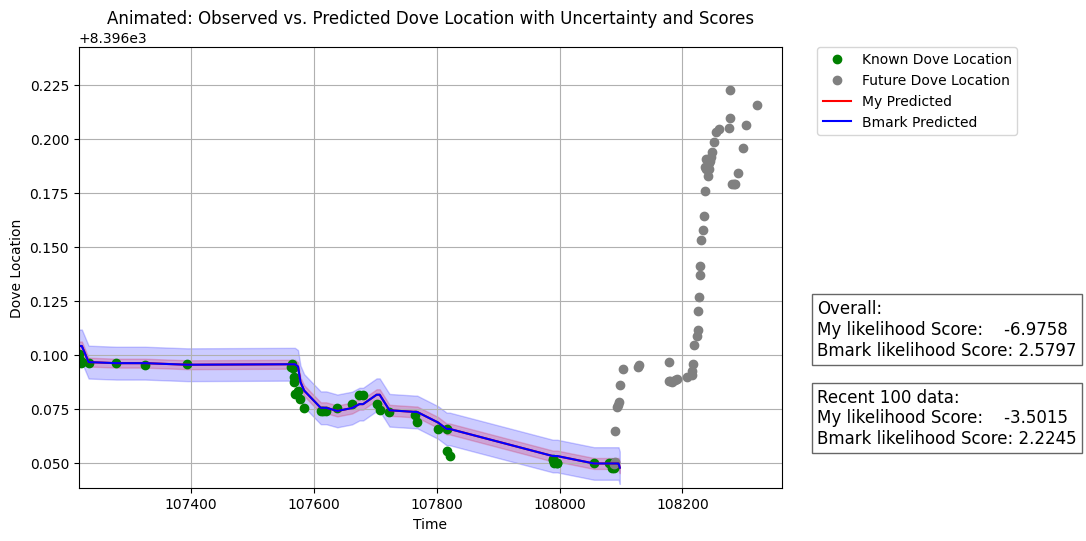

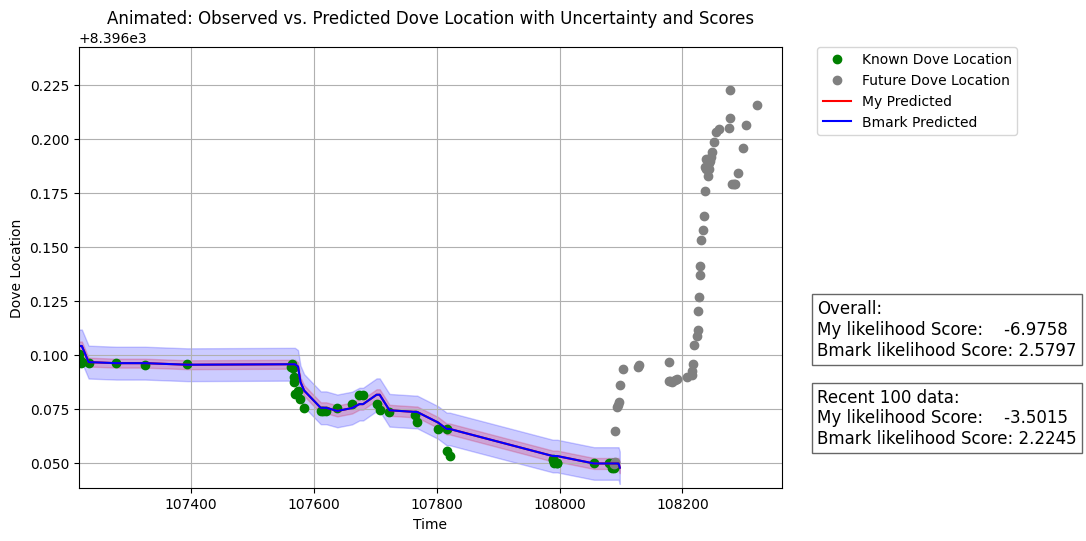

In [6]:
%matplotlib inline
from IPython.display import HTML

tracker = NGBoostTracker()

animated = tracker.test_run_animated(live=False, from_notebook=True)

# Display animation in notebook
HTML(animated.to_jshtml())
# Interrupt cell to stop run

### Design your own testing process and statistical analysis

In [7]:
from birdgame.model_benchmark.emwavartracker import EMWAVarTracker
from birdgame.trackers.tracker_evaluator import TrackerEvaluator
from birdgame.datasources.livedata import live_data_generator
from birdgame.datasources.remotetestdata import remote_test_data_generator
from birdgame.visualization.utils import get_loc_and_scale


live = False
step_print = 1000
warmup_iterations = 300
max_iterations = 10000

tracker = NGBoostTracker()

benchmark_tracker = EMWAVarTracker(horizon=tracker.horizon)
my_run, bmark_run = TrackerEvaluator(tracker), TrackerEvaluator(benchmark_tracker)

gen = live_data_generator() if live else remote_test_data_generator()

store_pred = []
try:
    for i, payload in enumerate(tqdm(gen)):

        my_run.tick_and_predict(payload)
        bmark_run.tick_and_predict(payload)

        if i > warmup_iterations:
            score = my_run.scores[-1]
            
            loc, scale = get_loc_and_scale(my_run.latest_valid_prediction)
            store_pred.append({
                "time": my_run.time,
                "prediction": my_run.latest_valid_prediction,
                "loc": loc,
                "scale": scale,
                "dove_location": my_run.dove_location,
                "score": score,
                "log_score": np.log(1e-10 + score)
            })

        if (i + 1) % step_print == 0:
            print(f"My likelihood score: {my_run.overall_likelihood_score():.4f} VS Benchmark likelihood score: {bmark_run.overall_likelihood_score():.4f}")

        if i > max_iterations:
            break

    print(f"My likelihood score: {my_run.overall_likelihood_score():.4f} VS Benchmark likelihood score: {bmark_run.overall_likelihood_score():.4f}")
except KeyboardInterrupt:
    print("Interrupted")

0it [00:00, ?it/s]

My likelihood score: -7.4690 VS Benchmark likelihood score: 2.5298
My likelihood score: -4.7583 VS Benchmark likelihood score: 2.4641
My likelihood score: -3.6628 VS Benchmark likelihood score: 2.4350
My likelihood score: -2.6480 VS Benchmark likelihood score: 2.5580
My likelihood score: -2.2540 VS Benchmark likelihood score: 2.6113
My likelihood score: -1.9701 VS Benchmark likelihood score: 2.6678
My likelihood score: -2.1218 VS Benchmark likelihood score: 2.5774
My likelihood score: -2.0879 VS Benchmark likelihood score: 2.4989
My likelihood score: -1.9784 VS Benchmark likelihood score: 2.4731
My likelihood score: -1.8742 VS Benchmark likelihood score: 2.4504
My likelihood score: -1.8734 VS Benchmark likelihood score: 2.4505


In [8]:
from birdgame.visualization.utils import summarize_predictions
stats_summary, pred_summary = summarize_predictions(store_pred, skip_length=0)

Mean: {'score': 41.675, 'log_score': -1.36}
Median: {'score': 33.884, 'log_score': 3.523}
Std: {'score': 46.368, 'log_score': 9.369}

Prediction Data:


,time,prediction,loc,scale,dove_location,score,log_score
0,99131.0,"{'type': 'mixture', 'components': [{'density':...",8396.23484,0.00050,8396.20651,0.00000,-23.02585
1,99134.0,"{'type': 'mixture', 'components': [{'density':...",8396.23484,0.00050,8396.20660,0.00000,-23.02585
2,99135.0,"{'type': 'mixture', 'components': [{'density':...",8396.22911,0.00046,8396.21083,0.00000,-23.02585
3,99136.0,"{'type': 'mixture', 'components': [{'density':...",8396.22642,0.00046,8396.21608,0.00000,-23.02585
4,99141.0,"{'type': 'mixture', 'components': [{'density':...",8396.20651,0.00046,8396.21939,0.00000,-23.02585
...,...,...,...,...,...,...,...
9696,187939.0,"{'type': 'mixture', 'components': [{'density':...",8395.18560,0.00250,8395.19369,0.84767,-0.16527
9697,187949.0,"{'type': 'mixture', 'components': [{'density':...",8395.19369,0.00250,8395.19147,107.43659,4.67690
9698,187950.0,"{'type': 'mixture', 'components': [{'density':...",8395.19369,0.00250,8395.18889,25.33491,3.23218
9699,187953.0,"{'type': 'mixture', 'components': [{'density':...",8395.19369,0.00250,8395.18732,6.19751,1.82415


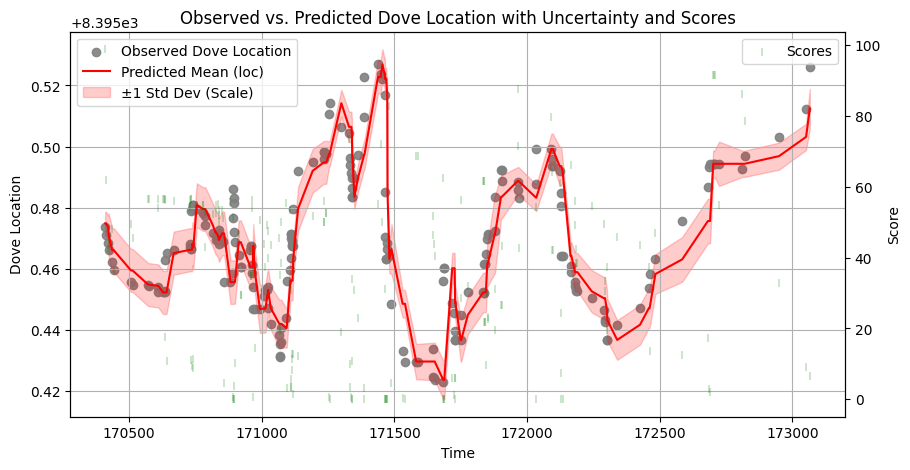

In [9]:
from birdgame.visualization.viz_predictions import plot_dove_predictions
start_ind=8000
window_size=200
plot_dove_predictions(store_pred, start_ind, window_size)